확인한 데이터를 어떤식으로 전처리를 할지
-이상치
내 목적을 이루는 딥러닝 추천모델을 설계(제작 or 찾아서 사용)
ex) CNN을 사용하거나,RNN을 사용하거나

모델의 성능 확인
(후에 모델을 선택한 이유를 발표해야함-가장 최신출시,가장 높은 정확도 같이 선택한 이유가 있어야함)
전처리를 무엇을 했는지(전처리의 전반적인 히스토리), 모델의 결과까지 설명해주면 됨


#### 가스공급량 수요예측 모델개발
Public 리더보드 : 전체 테스트 데이터 중 무작위 50%
본대회에서는 NMAE(Normalized Mean Absolute Error)-정규화 평균 절대 오차 척도를 사용하여 평가합니다.
import pandas as pd
import numpy as np


def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#### 코드 불러옴

In [2]:
gas_data = pd.read_csv('./gas/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949',index_col=0)
gas_data.head(2)

,시간,구분,공급량(톤)
연월일,,,
2013-01-01,1,A,2497.129
2013-01-01,2,A,2363.265


#### 전처리

In [3]:
# 원-핫 인코딩 적용
encoded_data = pd.get_dummies(gas_data, columns=['구분'])

# 인코딩된 데이터의 처음 몇 줄과 새로운 컬럼들 확인
encoded_data.head(2), encoded_data.columns


(            시간    공급량(톤)  구분_A   구분_B   구분_C   구분_D   구분_E   구분_G   구분_H
 연월일                                                                     
 2013-01-01   1  2497.129  True  False  False  False  False  False  False
 2013-01-01   2  2363.265  True  False  False  False  False  False  False,
 Index(['시간', '공급량(톤)', '구분_A', '구분_B', '구분_C', '구분_D', '구분_E', '구분_G', '구분_H'], dtype='object'))

In [3]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 초기화
label_encoder = LabelEncoder()

# `구분` 컬럼에 레이블 인코딩 적용
gas_data['구분_LE'] = label_encoder.fit_transform(gas_data['구분'])

# 인코딩된 데이터의 처음 몇 줄 확인
gas_data.head(), label_encoder.classes_

(            시간 구분    공급량(톤)  구분_LE
 연월일                               
 2013-01-01   1  A  2497.129      0
 2013-01-01   2  A  2363.265      0
 2013-01-01   3  A  2258.505      0
 2013-01-01   4  A  2243.969      0
 2013-01-01   5  A  2344.105      0,
 array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object))

In [4]:
gas_data.isnull().sum()

시간        0
구분        0
공급량(톤)    0
구분_LE     0
dtype: int64

In [5]:
gas_data['공급량(톤)'].describe()

count    368088.000000
mean        948.100037
std         927.211578
min           1.378000
25%         221.973000
50%         637.014000
75%        1398.919000
max       11593.617000
Name: 공급량(톤), dtype: float64

In [6]:
# 공급량(톤) 컬럼의 이상치 검출 - IQR 방식
Q1 = gas_data['공급량(톤)'].quantile(0.25)
Q3 = gas_data['공급량(톤)'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 범위 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 감지
outliers = gas_data[(gas_data['공급량(톤)'] < lower_bound) | (gas_data['공급량(톤)'] > upper_bound)]

lower_bound, upper_bound, outliers.shape

(-1543.4460000000004, 3164.3380000000006, (13184, 4))

In [7]:
gas_data[gas_data['공급량(톤)']>5000].count()

시간        418
구분        418
공급량(톤)    418
구분_LE     418
dtype: int64

In [8]:
# 이상치를 제외한 데이터
data_cleaned = gas_data[(gas_data['공급량(톤)'] >= lower_bound) & (gas_data['공급량(톤)'] <= upper_bound)]

# 이상치를 제거한 후의 데이터 형태
data_cleaned.shape

(354904, 4)

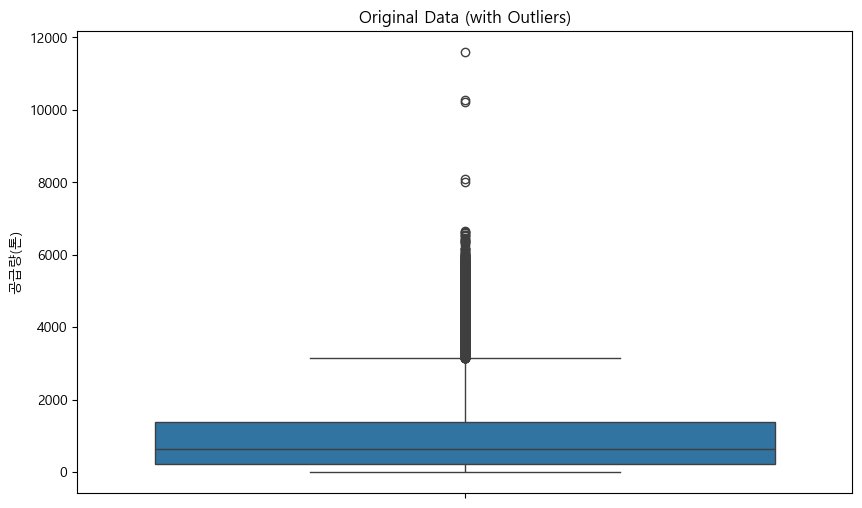

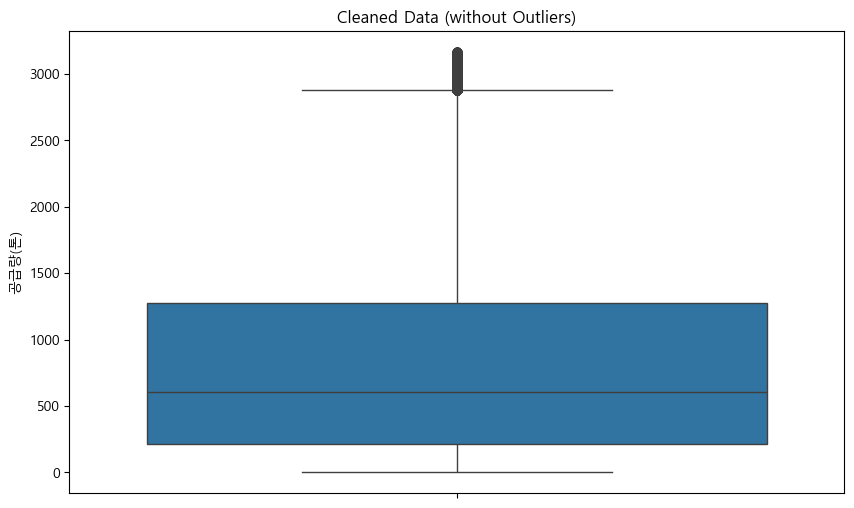

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] ='Malgun Gothic'

# 이상치를 포함한 원본 데이터의 공급량 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(gas_data['공급량(톤)'])
plt.title('Original Data (with Outliers)')

plt.show()

# 이상치를 제거한 데이터의 공급량 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data_cleaned['공급량(톤)'])
plt.title('Cleaned Data (without Outliers)')

plt.show()

In [10]:


dfx= gas_data[['시간','구분_LE','공급량(톤)']]
for col in dfx.columns:
    scaler = MinMaxScaler()
    dfx[col] = scaler.fit_transform(dfx[[col]])
dfy = dfx[['공급량(톤)']]    
dfx = dfx[['시간','구분_LE']]

x = dfx.values.tolist()
y = dfy.values.tolist()

C:\Users\user\AppData\Local\Temp\ipykernel_15072\2635870247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[col] = scaler.fit_transform(dfx[[col]])
C:\Users\user\AppData\Local\Temp\ipykernel_15072\2635870247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[col] = scaler.fit_transform(dfx[[col]])
C:\Users\user\AppData\Local\Temp\ipykernel_15072\2635870247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

가스 공급 예측모델을 추후에 사용하게 좋게 만들기 위해서는 빠른 학습과 리소스 사용을 최적화 할수 있는 모델인 GRU모델을 사용하였습니다.
GRU모델은 LSTM모델보다 파라미터수가 적기에 더 빠른 학습을 할 수 있으며 LSTM과 유사한 정확도를 달성할 수 있습니다.

In [11]:
window_size = 15
data_x, data_y = [], []

for i in range(len(y) - window_size):
    _x = x[i:i+window_size]
    _y = y[i+window_size]
    data_x.append(_x)
    data_y.append(_y)

In [12]:
train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_x.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_x.shape, test_y.shape)

훈련 데이터의 크기 : (294458, 15, 2) (294458, 1)
테스트 데이터의 크기 : (73615, 15, 2) (73615, 1)


In [14]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료 및 학습률 조정을 위한 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# 모델 정의 (더 단순화된 구조를 위해 레이어를 하나만 사용)
model = Sequential([
    # GRU 레이어 추가
    GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5), # 과적합 방지를 위한 Dropout 레이어
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1) # 출력 레이어
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
model.summary()

# 모델 학습 (배치 크기 증가)
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_loss)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 15, 64)            13056     
                                                                 
 dropout_2 (Dropout)         (None, 15, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22497 (87.88 KB)
Trainable params: 22497 (87.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4141/41

### 이상치,minmaxsacling
window_size = 15
GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5), # 과적합 방지를 위한 Dropout 레이어
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1) # 출력 레이어

epochs=50, batch_size=64, validation_split=0.1, verbose=2

2301/2301 [==============================] - 4s 2ms/step


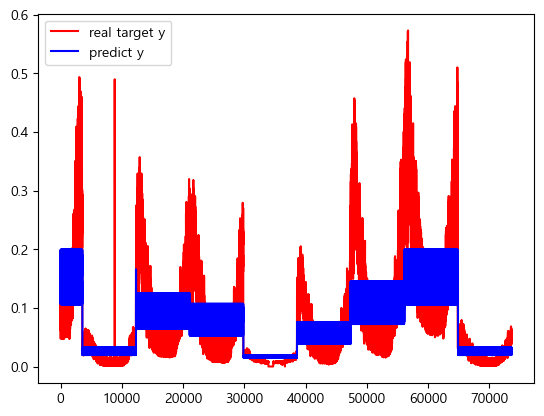

In [15]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real target y')
plt.plot(pred_y, color='blue', label='predict y')
plt.legend()
plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

# 데이터 불러오기
gas_data = pd.read_csv('./gas/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949', index_col=0)

# 원-핫 인코딩 적용
gas_data_encoded = pd.get_dummies(gas_data, columns=['구분'])

# 이상치 제거와 표준화를 위한 데이터 준비
dfx = gas_data_encoded.drop('공급량(톤)', axis=1)
dfy = gas_data_encoded['공급량(톤)']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dfx_scaled = scaler_x.fit_transform(dfx)
dfy_scaled = scaler_y.fit_transform(dfy.values.reshape(-1, 1))

# 시퀀스 데이터 준비
def create_dataset(X, y, window_size=5):
    data_x, data_y = [], []
    for i in range(len(X) - window_size):
        data_x.append(X[i:(i + window_size)])
        data_y.append(y[i + window_size])
    return np.array(data_x), np.array(data_y)

data_x, data_y = create_dataset(dfx_scaled, dfy_scaled, window_size=5)

# 데이터 분할
train_size = int(len(data_y) * 0.8)
train_x, train_y = data_x[:train_size], data_y[:train_size]
test_x, test_y = data_x[train_size:], data_y[train_size:]

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료 및 학습률 조정을 위한 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# GRU 모델 구성
model = Sequential([
    GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 모델 학습
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_loss)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             14208     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 23649 (92.38 KB)
Trainable params: 23649 (92.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4141/4141

window_size=5
GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1)
epochs=50, batch_size=64, validation_split=0.1, verbose=2

2301/2301 [==============================] - 3s 1ms/step


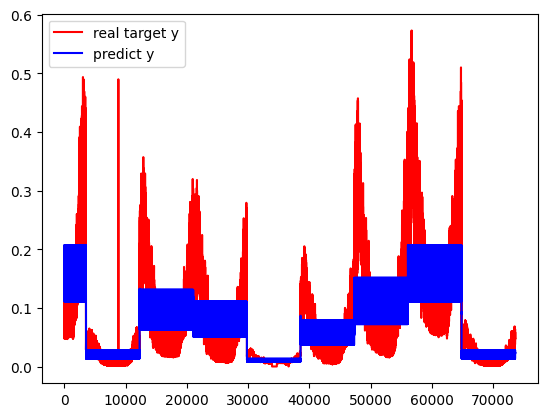

In [3]:
import matplotlib.pyplot as plt
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real target y')
plt.plot(pred_y, color='blue', label='predict y')
plt.legend()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

# 데이터 불러오기
gas_data = pd.read_csv('./gas/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949', index_col=0)

# 원-핫 인코딩 적용
gas_data_encoded = pd.get_dummies(gas_data, columns=['구분'])

# 이상치 제거와 표준화를 위한 데이터 준비
dfx = gas_data_encoded.drop('공급량(톤)', axis=1)
dfy = gas_data_encoded['공급량(톤)']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dfx_scaled = scaler_x.fit_transform(dfx)
dfy_scaled = scaler_y.fit_transform(dfy.values.reshape(-1, 1))

# 시퀀스 데이터 준비
def create_dataset(X, y, window_size=10):
    data_x, data_y = [], []
    for i in range(len(X) - window_size):
        data_x.append(X[i:(i + window_size)])
        data_y.append(y[i + window_size])
    return np.array(data_x), np.array(data_y)

data_x, data_y = create_dataset(dfx_scaled, dfy_scaled, window_size=5)

# 데이터 분할
train_size = int(len(data_y) * 0.8)
train_x, train_y = data_x[:train_size], data_y[:train_size]
test_x, test_y = data_x[train_size:], data_y[train_size:]

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료 및 학습률 조정을 위한 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# GRU 모델 구성
model = Sequential([
    GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 모델 학습
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_loss)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 64)             14208     
                                                                 
 dropout_6 (Dropout)         (None, 5, 64)             0         
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23649 (92.38 KB)
Trainable params: 23649 (92.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4141/41

In [14]:
print(test_x.shape)


(73617, 5, 8)


2301/2301 [==============================] - 3s 1ms/step


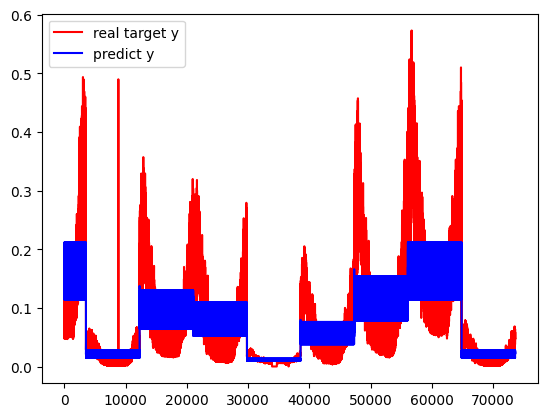

In [10]:
import matplotlib.pyplot as plt
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real target y')
plt.plot(pred_y, color='blue', label='predict y')
plt.legend()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18688     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 28129 (109.88 KB)
Trainable params: 28129 (109.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4141/41

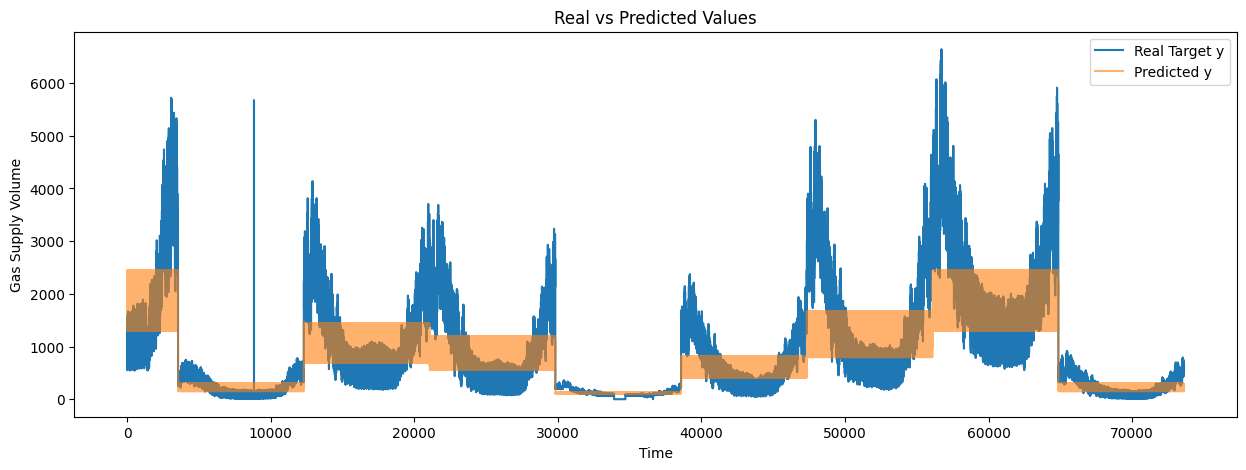

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 데이터 불러오기
gas_data = pd.read_csv('./gas/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949', index_col=0)

# 원-핫 인코딩 적용
gas_data_encoded = pd.get_dummies(gas_data, columns=['구분'])

# 이상치 제거와 표준화를 위한 데이터 준비
dfx = gas_data_encoded.drop('공급량(톤)', axis=1)
dfy = gas_data_encoded['공급량(톤)']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

dfx_scaled = scaler_x.fit_transform(dfx)
dfy_scaled = scaler_y.fit_transform(dfy.values.reshape(-1, 1))

# 시퀀스 데이터 준비
def create_dataset(X, y, window_size=5):
    data_x, data_y = [], []
    for i in range(len(X) - window_size):
        data_x.append(X[i:(i + window_size)])
        data_y.append(y[i + window_size])
    return np.array(data_x), np.array(data_y)

data_x, data_y = create_dataset(dfx_scaled, dfy_scaled, window_size=5)

# 데이터 분할
train_size = int(len(data_y) * 0.8)
train_x, train_y = data_x[:train_size], data_y[:train_size]
test_x, test_y = data_x[train_size:], data_y[train_size:]

# 조기 종료 및 학습률 조정을 위한 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# LSTM과 GRU를 함께 사용하는 모델 구성
model = Sequential([
    LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 모델 학습
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_loss)

# 예측 실행
predictions_scaled = model.predict(test_x)

# 예측 결과를 원래의 스케일로 되돌림
predictions = scaler_y.inverse_transform(predictions_scaled)

# 실제 테스트 데이터의 y 값들을 원래의 스케일로 되돌림
y_test_true = scaler_y.inverse_transform(test_y.reshape(-1, 1))

# 연속적인 시계열 데이터로 예측 결과를 플롯합니다.
plt.figure(figsize=(15, 5))
plt.plot(y_test_true, label='Real Target y')
plt.plot(predictions, label='Predicted y', alpha=0.6)
plt.title('Real vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Gas Supply Volume')
plt.legend()
plt.show()


In [8]:
print(test_x.shape)

(73617, 5, 8)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 5, 64)             14208     
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23649 (92.38 KB)
Trainable params: 23649 (92.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3993/39

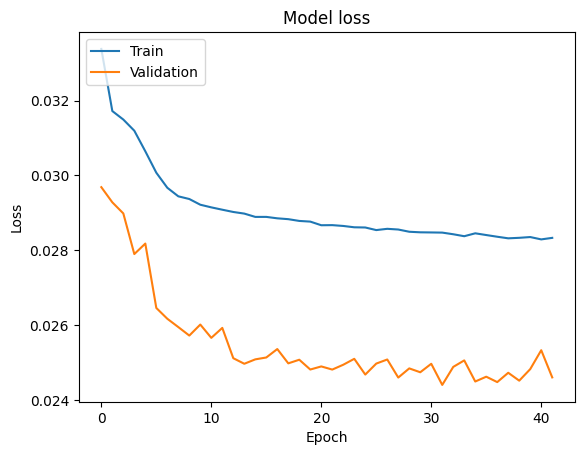

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
import matplotlib.pyplot as plt

# 데이터 불러오기
gas_data = pd.read_csv('./gas/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949', index_col=0)

# 원-핫 인코딩 적용
gas_data_encoded = pd.get_dummies(gas_data, columns=['구분'])

# 결측치 처리 (여기서는 평균값으로 대체하는 예시를 들지만, 실제로는 다른 방법을 적용할 수 있음)
gas_data_encoded.fillna(gas_data_encoded.mean(), inplace=True)

# 이상치 제거
Q1 = gas_data_encoded['공급량(톤)'].quantile(0.25)
Q3 = gas_data_encoded['공급량(톤)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
gas_data_cleaned = gas_data_encoded[(gas_data_encoded['공급량(톤)'] >= lower_bound) & (gas_data_encoded['공급량(톤)'] <= upper_bound)]

# 데이터 준비
dfx = gas_data_cleaned.drop(['공급량(톤)'], axis=1)
dfy = gas_data_cleaned['공급량(톤)']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
dfx_scaled = scaler_x.fit_transform(dfx)
dfy_scaled = scaler_y.fit_transform(dfy.values.reshape(-1, 1))

# 시퀀스 데이터 준비
def create_dataset(X, y, window_size=5):
    data_x, data_y = [], []
    for i in range(len(X) - window_size):
        data_x.append(X[i:(i + window_size)])
        data_y.append(y[i + window_size])
    return np.array(data_x), np.array(data_y)

data_x, data_y = create_dataset(dfx_scaled, dfy_scaled, window_size=5)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료 및 학습률 조정을 위한 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# 데이터 분할
train_size = int(len(data_y) * 0.8)
train_x, train_y = data_x[:train_size], data_y[:train_size]
test_x, test_y = data_x[train_size:], data_y[train_size:]

# GRU 모델 구성
model = Sequential([
    GRU(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 모델 학습
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_loss)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


2219/2219 [==============================] - 3s 1ms/step


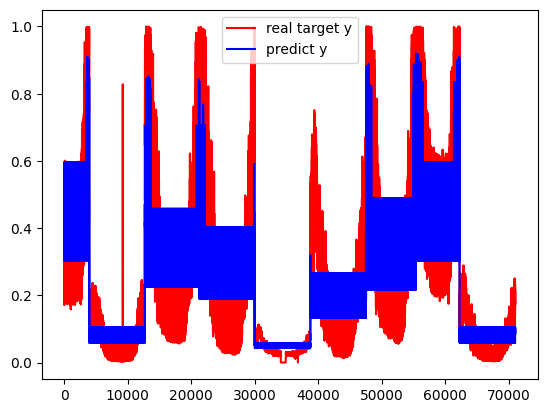

In [6]:
import matplotlib.pyplot as plt
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real target y')
plt.plot(pred_y, color='blue', label='predict y')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from deepctr.models import WDL, NFM
from deepctr.feature_column import SparseFeat, get_feature_names
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 데이터 불러오기
train = pd.read_csv('./book/train.csv', encoding='utf-8')
test = pd.read_csv('./book/test.csv', encoding='utf-8')

# 평점이 0인 경우 유저가 해당 도서에 관심이 없고 관련이 없는 경우 이므로 
# 평점을 계산할 때 0을 포함시키지않고 계산
train= train[train['Book-Rating']>0]

# 출판연도가 -1일 경우 결측 혹은 알 수 없음 값이므로 제외
train= train[train['Year-Of-Publication']!=-1]

# 세계 최고령인 사람이 122살 까지 이므로 123살 이상은 제외
# 논리적으로 사고가 가능한 나이를 대략적으로 7세로 가정하고 그 이하는 제외
train=train[(train['Age']<122) & (train['Age']>7)]

#추가적인 전처리
# 평점을 극단적으로 높이 주거나 낮게 주는 유저가 있을수 있지만 그건 유저의 특성이라고 생각하므로 제거하지않음

def age_range(x):
    if x < 10:
        return "00대"
    elif x < 20 :
        return "10대"
    elif x < 30 :
        return "20대"
    elif x < 40 :
        return "30대"
    elif x < 50 :
        return "40대"
    elif x < 60 :
        return "50대"
    elif x < 70 :
        return "60대"
    elif x < 80 :
        return "70대"
    elif x < 90 :
        return "80대"
    elif x < 100 :
        return "90대"
    elif x < 110 :
        return "100대"
    elif x < 120 :
        return "110대"
    elif x >=120 :
        return "120대"

# 연령대 범주 생성
train["age_range"] = train["Age"].apply(lambda x: age_range(x))
test["age_range"] = test["Age"].apply(lambda x: age_range(x))

# OneHotEncoder 초기화 및 학습
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')  
# 알려지지 않은 카테고리는 모든값을0으로 채움
# 테스트 데이터에 '120대'에 대한 데이터가 없어서 0으로 채워짐
train_cat = ohe.fit_transform(train[['age_range']])
test_cat = ohe.transform(test[['age_range']])


# OneHotEncoder 초기화 및 학습 (이미 제공된 코드를 기반으로 함)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')  # 알려지지 않은 카테고리는 모든 값을 0으로 채움
train_cat = ohe.fit_transform(train[['age_range']])
test_cat = ohe.transform(test[['age_range']])

# 피처 컬럼 정의 (이미 제공된 코드를 기반으로 함)
sparse_features = ['age_range']
target = ['Book-Rating']

feature_columns = [SparseFeat(feat, vocabulary_size=len(train[feat].unique()), embedding_dim=4) for feat in sparse_features]
feature_names = get_feature_names(feature_columns)

# 모델 정의 및 훈련 (위에서 제공된 방식으로 조정)
# 여기에서는 훈련 데이터와 테스트 데이터를 바로 사용

# Wide & Deep 모델
wdl_model = WDL(feature_columns, feature_columns, task='regression')
wdl_model.compile("adam", "mse", metrics=['mse'])
wdl_model.fit(train_cat, train[target].values, batch_size=256, epochs=10, verbose=2)

# NFM 모델
nfm_model = NFM(feature_columns, feature_columns, task='regression')
nfm_model.compile("adam", "mse", metrics=['mse'])
nfm_model.fit(train_cat, train[target].values, batch_size=256, epochs=10, verbose=2)

# 각 모델의 예측값 계산
wdl_pred = wdl_model.predict(test_cat)
nfm_pred = nfm_model.predict(test_cat)

# 두 모델의 예측값 평균 계산
final_pred = (wdl_pred + nfm_pred) / 2

# 최종 예측값을 파일로 저장
test['Book-Rating-Pred'] = final_pred
test.to_csv('./book/test_predictions.csv', index=False)


c:\Users\user\Desktop\LectureFiles\ploblem\myvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\Desktop\LectureFiles\ploblem\myvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

In [1]:
import pandas as pd

# 파일 경로
train_file_path = './book/train.csv'
test_file_path = './book/test.csv'

# 데이터 불러오기
train = pd.read_csv(train_file_path, encoding='utf-8')
test = pd.read_csv(test_file_path, encoding='utf-8')

# 데이터 전처리
train = train[train['Book-Rating'] > 0]
train = train[train['Year-Of-Publication'] != -1]
train = train[(train['Age'] < 122) & (train['Age'] > 7)]

def age_range(x):
    if x < 10: return "00대"
    elif x < 20: return "10대"
    elif x < 30: return "20대"
    elif x < 40: return "30대"
    elif x < 50: return "40대"
    elif x < 60: return "50대"
    elif x < 70: return "60대"
    elif x < 80: return "70대"
    elif x < 90: return "80대"
    elif x < 100: return "90대"
    elif x < 110: return "100대"
    elif x < 120: return "110대"
    else: return "120대"

train["age_range"] = train["Age"].apply(age_range)
test["age_range"] = test["Age"].apply(age_range)

# 전처리 결과 확인
train.head(2), test.head(2)


(             ID     User-ID      Book-ID  Book-Rating   Age  \
 0  TRAIN_000000  USER_00000  BOOK_044368            8  23.0   
 1  TRAIN_000001  USER_00000  BOOK_081205            8  23.0   
 
                            Location                         Book-Title  \
 0  sackville, new brunswick, canada                         Road Taken   
 1  sackville, new brunswick, canada  Macbeth (New Penguin Shakespeare)   
 
            Book-Author  Year-Of-Publication      Publisher age_range  
 0           Rona Jaffe               2001.0           Mira       20대  
 1  William Shakespeare               1981.0  Penguin Books       20대  ,
             ID     User-ID      Book-ID   Age              Location  \
 0  TEST_000000  USER_00008  BOOK_047966  37.0  vermilion, ohio, usa   
 1  TEST_000001  USER_00008  BOOK_119494  37.0  vermilion, ohio, usa   
 
                            Book-Title Book-Author  Year-Of-Publication  \
 0  Birds of Prey: A Novel of Suspense  J.A. Jance               2002

In [5]:
from sklearn.preprocessing import LabelEncoder
from deepctr.feature_column import SparseFeat, get_feature_names
from deepctr.models import WDL
import numpy as np

# "120대" 라벨을 처리하기 위한 더미 데이터 추가
if "120대" not in train['age_range'].unique():
    # 더미 행 추가
    dummy_row = train.iloc[0].copy()
    dummy_row['age_range'] = "120대"
    train = train.append(dummy_row, ignore_index=True)

# Label Encoding 재수행
le = LabelEncoder()
train['age_range'] = le.fit_transform(train['age_range'])
test['age_range'] = le.transform(test['age_range'])

# 이후 모델 정의 및 학습 과정을 계속 진행...

# Label Encoding for 'age_range' to use in DeepCTR models
le = LabelEncoder()
train['age_range'] = le.fit_transform(train['age_range'])
test['age_range'] = le.transform(test['age_range'])

# Define feature columns for DeepCTR
sparse_features = ['age_range']
target = ['Book-Rating']

# SparseFeat를 사용해 feature_columns를 생성
feature_columns = [SparseFeat(feat, vocabulary_size=train[feat].nunique(), embedding_dim=4) for feat in sparse_features]
feature_names = get_feature_names(feature_columns)

# 모델 정의 (WDL: Wide & Deep Learning)
model = WDL(linear_feature_columns=feature_columns, dnn_feature_columns=feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'])

# 모델 학습을 위한 입력 데이터 준비
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# 모델 학습
history = model.fit(train_model_input, train[target].values, batch_size=256, epochs=10, verbose=2)

# 모델을 사용한 예측
predictions = model.predict(test_model_input, batch_size=256)

# 예측값 확인
predictions[:5]


ModuleNotFoundError: No module named 'deepctr'

In [3]:
!pip install deepctr